In [1]:
# Install Folium
#pip install folium
# Install Dtale data frame visualization package
#!pip install --upgrade dtale


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


import dtale # data Frame visualization

import datetime   # handle date times
import re         # regular expression package

In [3]:
# Check if data has been pickled and if so load pickle
if os.path.exists('data/txDF.pkl') :
    txDF=pd.read_pickle('data/txDF.pkl',compression='gzip')
    tx_metro_cities_df = pd.read_pickle('data/tx_metro_cities.pkl',compression='gzip')    
else:
# pickle only the attributes we are interested in, and compress
# pickle is much faster/smaller than csv
    df = pd.read_csv('data/US_Accidents_Dec19.csv',encoding='utf-8')
    columns_of_interest=[
        'ID','Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'City', 
        'County', 'State','Zipcode', 'Country','Visibility(mi)', 
        'Weather_Condition','Precipitation(in)','Sunrise_Sunset','Civil_Twilight'
    ]
    condition=df['State'] =='TX'
    txDF=df[condition][columns_of_interest]
    #create df for selected cities 
    tx_metro_cities =  ['Austin', 'Round Rock', 'Cedar Park',
                 'San Marcos', 'Georgetown', 'Pflugerville',
                 'Hutto', 'Buda', 'Kyle', 'Leander',
                 'Dallas', 'Fort Worth', 'Arlington', 
                 'Plano','Garland', 'Irving', 'McKinney', 
                 'Frisco','Denton','Richardson', 'Allen','El Paso',
                 'Houston', 'The Woodlands', 'Sugar Land',
                 'Baytown', 'Conroe','San Antonio', 'New Braunfels', 
                 'Schertz', 'Seguin']
    condition = txDF['City'].isin(tx_metro_cities)
    tx_metro_cities_df = txDF[condition]    
    txDF.to_pickle("data/txDF.pkl",compression='gzip')
    tx_metro_cities_df.to_pickle("data/tx_metro_cities.pkl",compression='gzip')

# Date Attributes

Separate the *start_time* attribute into it several date components


In [4]:
# code fron fast ai
# Date Feature Engineering
# will split data colum in to corresponding 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'
def add_datepart(df, fldname, drop=True,time=False):
    fld = df[fldname]
    attributes = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attributes = attributes + ['Hour', 'Minute', 'Second']
    #, 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in attributes:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [5]:
add_datepart(tx_metro_cities_df,'Start_Time',False,True )
tx_metro_cities_df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)',
       'Weather_Condition', 'Precipitation(in)', 'Sunrise_Sunset',
       'Civil_Twilight', 'Start_TimeYear', 'Start_TimeMonth', 'Start_TimeWeek',
       'Start_TimeDay', 'Start_TimeDayofweek', 'Start_TimeDayofyear',
       'Start_TimeHour', 'Start_TimeMinute', 'Start_TimeSecond',
       'Start_TimeElapsed'],
      dtype='object')

In [6]:
def dow(df):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return days[df]
    

tx_metro_cities_df['Start_TimeDayofweek'] =tx_metro_cities_df['Start_TimeDayofweek'].apply(dow)


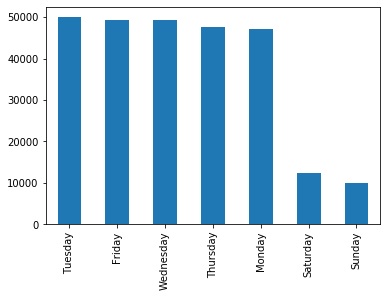

In [7]:
tx_metro_cities_df['Start_TimeDayofweek'].value_counts().plot(kind='bar')

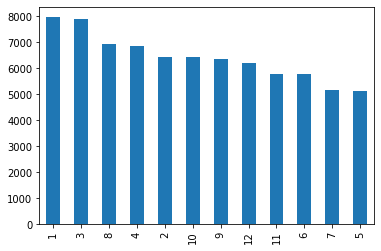

In [8]:
condition = tx_metro_cities_df['Start_TimeYear'] == 2017

tx_metro_cities_df[condition]['Start_TimeMonth'].value_counts().plot(kind='bar')


In [9]:
def plot_map1(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()
    data_heatmap = data_heatmap[['Start_Lat','Start_Lng']]
    data_heatmap = [[row['Start_Lat'],row['Start_Lng']] for index, row in data_heatmap.iterrows()]
    HeatMap(data_heatmap, radius=10).add_to(accident_map)
    return accident_map

## Weekday Accidents



In [10]:
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
weekenddays =["Saturday","Sunday"]


In [11]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017)  & (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekdays))
plot_map1(tx_metro_cities_df[condition],[30.2672,-97.7431])


In [12]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017)  & (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekenddays))
plot_map1(tx_metro_cities_df[condition],[30.2672,-97.7431])

# Accidents in one Day



In [13]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')
vc = tx_metro_cities_df[condition]['Start_TimeDayofyear'].value_counts().head()
vc

51     101
345     99
341     97
288     90
299     89
Name: Start_TimeDayofyear, dtype: int64

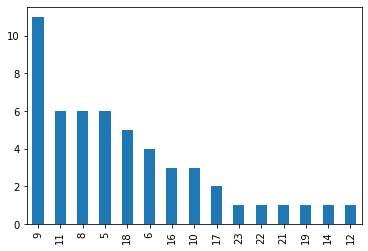

In [14]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017) & (tx_metro_cities_df['City'] == 'Austin')  & (tx_metro_cities_df['Start_TimeDayofyear']==51)
tx_metro_cities_df[condition]['Start_TimeHour'].value_counts().plot(kind='bar')

Group times in ranges to 

* Morning Rush 6:00-9:59 AM
* Evening Rush 4:00-7:59 PM

In [15]:
timeBins = [0,5,9,13,16,19,24]
groupNames = ['<5','6-9','10-13','14-16','16-19','19-24']
tx_metro_cities_df['HourGroup']=pd.cut(tx_metro_cities_df['Start_TimeHour'],timeBins, labels=groupNames)
tx_metro_cities_df['HourGroup'].head()
tx_metro_cities_df.shape

(265605, 27)

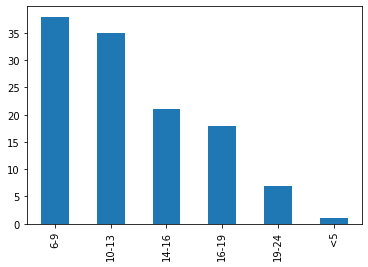

In [17]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017) & (tx_metro_cities_df['City'] == 'Austin')  & (tx_metro_cities_df['Start_TimeDayofyear']==340)
tx_metro_cities_df[condition]['HourGroup'].value_counts().plot(kind='bar')

In [18]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017) & (tx_metro_cities_df['City'] == 'Austin')  & (tx_metro_cities_df['Start_TimeDayofyear']==340)
onedf=tx_metro_cities_df[condition].sort_values('Start_TimeHour')

print(len(onedf))
import dtale
d= dtale.show(onedf,ignore_duplicate=True)
d

120


In [25]:
def plot_heatmapWithTime(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()

    daylist = []
    for day in data_heatmap.Start_TimeDayofyear.sort_values().unique():
        daylist.append(data_heatmap.loc[data_heatmap.Start_TimeDayofyear == day, ['Start_Lat','Start_Lng']].groupby(['Start_Lat', 'Start_Lng']).sum().reset_index().values.tolist())   
    print(len(daylist))
    HeatMapWithTime(daylist, auto_play=True, radius=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=False).add_to(accident_map)
   

    return accident_map

In [26]:
#condition = (tx_metro_cities_df['Start_TimeYear'] == 2019)  & (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekenddays))  & (txDF['City'] == 'Austin')
condition = (tx_metro_cities_df['Start_TimeYear'] == 2017)   & (txDF['City'] == 'Austin')
plot_heatmapWithTime(tx_metro_cities_df[condition],[30.2672,-97.7431])

e:\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



332
